In [1]:
"""
SPOD Python toolkit Ver 1.2

The script was originally written for analyzing compressor tip leakage flows:
    
  He, X., Fang, Z., Vahdati, M. & Rigas, G., (2021). Spectral Proper Orthogonal 
  Decomposition of Compressor Tip Leakage Flow. Physics of Fluids, 33(10).
  
An explict reference to the work above is highly appreciated if this script is
useful for your research.  

Xiao He (xiao.he2014@imperial.ac.uk), Zhou Fang
Last update: 24-Sep-2021
"""

# -------------------------------------------------------------------------
# import libraries
import numpy as np
from scipy.fft import fft, ifft
from scipy.special import gammaincinv
import time
import os
import psutil
import h5py
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# main function
def spod(x,dt,save_path,weight='default',nOvlp='default',nDFT='default',window='default',
         method='lowRAM'):
    '''
    Purpose: main function of spectral proper orthogonal decomposition
             (Towne, A., Schmidt, O., and Colonius, T., 2018, arXiv:1708.04393v2)
        
    Parameters
    ----------
    x         : 2D numpy array, float; space-time flow field data.
                nrow = number of time snapshots;
                ncol = number of grid point * number of variable
    dt        : float; time step between adjacent snapshots
    save_path : str; path to save the output data
    weight    : 1D numpy array; weight function (default unity)
                n = number of grid point * number of variable
    nOvlp     : int; number of overlap (default 50% nDFT)
    nDFT      : int; number of DFT points (default about 10% of number of time snapshots)    
    window    : 1D numpy array, float; window function values (default Henning)
                n = nDFT (default nDFT calculated from number of time snapshots)
    method    : string; 'fast' for fastest speed, 'lowRAM' for lowest RAM usage


    Return
    -------
    The SPOD results are written in the file '<save_path>/SPOD_LPf.h5'
    SPOD_LPf['L'] : 2D numpy array, float; modal energy E(f, M)
                    nrow = number of frequencies
                    ncol = number of modes (ranked in descending order by modal energy)
    SPOD_LPf['P'] : 3D numpy array, complex; mode shape
                    P.shape[0] = number of frequencies;
                    P.shape[1] = number of grid point * number of variable
                    P.shape[2] = number of modes (ranked in descending order by modal energy)
    SPOD_LPf['f'] : 1D numpy array, float; frequency
    '''
    
    time_start=time.time()

    print('--------------------------------------')  
    print('SPOD starts...'                        )
    print('--------------------------------------')    
    
    # ---------------------------------------------------------
    # 1. calculate SPOD parameters
    # ---------------------------------------------------------
    nt = np.shape(x)[0]
    nx = np.shape(x)[1]
     
    # SPOD parser
    [weight, window, nOvlp, nDFT, nBlks] = spod_parser(nt, nx, window, weight, nOvlp, nDFT, method)


    #---------------------------------------------------------
    # 2. loop over number of blocks and generate Fourier 
    #    realizations (DFT)
    #---------------------------------------------------------
    print('--------------------------------------')
    print('Calculating temporal DFT'              )
    print('--------------------------------------')
 
    # calculate time-averaged result
    x_mean  = np.mean(x,axis=0)

    # obtain frequency axis
    f     = np.arange(0,int(np.ceil(nDFT/2)+1))
    f     = f/dt/nDFT
    nFreq = f.shape[0]   
    
    # initialize all DFT result in frequency domain
    if method == 'fast':
        Q_hat = np.zeros((nx,nFreq,nBlks),dtype = complex) # RAM demanding here       
        
    elif method == 'lowRAM':
        Q_hat = h5py.File(os.path.join(save_path,'Q_hat.h5'), 'w')
        Q_hat.create_dataset('Q_hat', shape=(nx,nFreq,nBlks), chunks=True, dtype = complex, compression="gzip")
        
    # initialize block data in time domain
    Q_blk = np.zeros((nDFT,nx))
    Q_blk_hat = np.zeros((nx,nFreq),dtype = complex)
    
    # loop over each block
    for iBlk in range(nBlks):
        
        # get time index for present block
        it_end   = min(iBlk*(nDFT-nOvlp)+nDFT, nt)
        it_start = it_end-nDFT
                    
        print('block', iBlk+1, '/', nBlks, '(', it_start+1, ':', it_end, ')')
        
        # subtract time-averaged results from the block
        Q_blk = x[it_start:it_end,:] - x_mean # column-wise broadcasting
        
        # add window function to block
        Q_blk = Q_blk.T * window # row-wise broadcasting
       
        # Fourier transform on block
        Q_blk_hat = 1/np.mean(window)/nDFT*fft(Q_blk)       
        Q_blk_hat = Q_blk_hat[:,0:nFreq]           
        
        # correct Fourier coefficients for one-sided spectrum
        Q_blk_hat[:,1:(nFreq-1)] *= 2
        
        # save block result to the whole domain result 
        if method == 'fast':
            Q_hat[:,:,iBlk] = Q_blk_hat
            
        elif method == 'lowRAM':
            Q_hat['Q_hat'][:,:,iBlk] = Q_blk_hat

    # remove vars to release RAM
    del x, Q_blk, Q_blk_hat
        
    #---------------------------------------------------------
    # 3. loop over all frequencies and calculate SPOD
    #---------------------------------------------------------
    print('--------------------------------------')
    print('Calculating SPOD'                      )
    print('--------------------------------------')
    
    # initialize output vars
    if method == 'fast':
        L = np.zeros((nFreq,nBlks))
        P = np.zeros((nFreq,nx,nBlks),dtype = complex) # RAM demanding here
        
    elif method == 'lowRAM':
        h5f = h5py.File(os.path.join(save_path,'SPOD_LPf.h5'), 'w')
        h5f.create_dataset('L', shape=(nFreq,nBlks), compression="gzip")
        h5f.create_dataset('P', shape=(nFreq,nx,nBlks), chunks=True, dtype = complex, compression="gzip")
        h5f.create_dataset('f', data=f, compression="gzip")     
    
    # loop over each frequency
    for iFreq in range(nFreq):
        print('Frequency',iFreq+1,'/',nFreq,'(f = %.3f'%f[iFreq],')')
        
        if method == 'fast':
            Q_hat_f = Q_hat[:,iFreq,:]
        
        elif method == 'lowRAM':
            Q_hat_f = Q_hat['Q_hat'][:,iFreq,:]
        
        M = np.dot(np.conjugate(Q_hat_f).T * weight, Q_hat_f)/nBlks
        
        # solve eigenvalue problem
        [Lambda, Theta] = np.linalg.eig(M)
        
        # sort modes by eigenvalues
        sort_idx = np.argsort(-Lambda)
        Lambda = Lambda[sort_idx]
        Theta = Theta[:,sort_idx]

        # save result to the output
        if method == 'fast':
            P[iFreq,:,:] = np.dot(np.dot(Q_hat_f,Theta),np.diag(1./np.sqrt(Lambda)/np.sqrt(nBlks)))
            L[iFreq,:] = np.abs(np.array(Lambda))
        
        elif method == 'lowRAM':
            h5f['P'][iFreq,:,:] = np.dot(np.dot(Q_hat_f,Theta),np.diag(1./np.sqrt(Lambda)/np.sqrt(nBlks)))
            h5f['L'][iFreq,:] = np.abs(np.array(Lambda))
    
    # save results to file
    print('--------------------------------------')
    print('Saving SPOD results...'                )
    
    if method == 'fast':
        h5f = h5py.File(os.path.join(save_path,'SPOD_LPf.h5'), 'w')
        h5f.create_dataset('L', data=L, compression="gzip")
        h5f.create_dataset('P', data=P, compression="gzip")
        h5f.create_dataset('f', data=f, compression="gzip")
        h5f.close()
    
    elif method == 'lowRAM':
        h5f.close()
        Q_hat.close()

    print('SPOD results saved to HDF5 file' )
    print('--------------------------------------'  )
                
    # memory usage
    process   = psutil.Process(os.getpid())
    RAM_usage = process.memory_info().rss/1024**3 # unit in GBs
        
    time_end=time.time()
    print('--------------------------------------'     )
    print('SPOD finished'                              )
    print('Memory usage: %.2f GB'%RAM_usage            )
    print('Run time    : %.2f s'%(time_end-time_start) )
    print('--------------------------------------'     )
    
    return


# -------------------------------------------------------------------------
# sub-functions
# -------------------------------------------------------------------------
def spod_parser(nt, nx, window, weight, nOvlp, nDFT, method):
    '''
    Purpose: determine data structure/shape for SPOD
        
    Parameters
    ----------
    nt     : int; number of time snapshots
    nx     : int; number of grid point * number of variable
    window : expect 1D numpy array, float; specified window function values
    weight : expect 1D numpy array; specified weight function
    nOvlp  : expect int; specified number of overlap
    nDFT   : expect int; specified number of DFT points (expect to be same as weight.shape[0])
    method : expect string; specified running mode of SPOD
    
    Returns
    -------
    weight : 1D numpy array; calculated/specified weight function
    window : 1D numpy array, float; window function values
    nOvlp  : int; calculated/specified number of overlap
    nDFT   : int; calculated/specified number of DFT points
    nBlks  : int; calculated/specified number of blocks
    '''

    # check SPOD running method
    try:
        # user specified method
        if method not in ['fast', 'lowRAM']:
            print('WARNING: user specified method not supported')
            raise ValueError
        else:
            print('Using user specified method...')
            
    except:        
        # default method
        method = 'lowRAM'
        print('Using default low RAM method...')
    
    # check specified weight function value
    try:
        # user specified weight
        nweight = weight.shape[0]
        if nweight != nx:
            print('WARNING: weight does not match with x')
            raise ValueError
        else:
            wgt_name = 'user specified'
            print('Using user specified weight...')
            
    except:        
        # default weight
        weight   = np.ones(nx)
        wgt_name = 'unity'
        print('Using default weight...')
                
    
    # calculate or specify window function value
    try:
        # user sepcified window
        nWinLen  = window.shape[0]
        win_name = 'user specified'
        nDFT     = nWinLen # use window shape to over-write nDFT (if specified)
        print('Using user specified nDFT from window length...')         
        print('Using user specified window function...')  
        
    except:
        # default window with specified/default nDFT
        try:
            # user specified nDFT
            nDFT  = int(nDFT)
            nDFT  = int(2**(np.floor(np.log2(nDFT)))) # round-up to 2**n type int
            print('Using user specified nDFT ...')             
                
        except:
            # default nDFT
            nDFT  = 2**(np.floor(np.log2(nt/10))) #!!! why /10 is recommended?
            nDFT  = int(nDFT)
            print('Using default nDFT...')
            
        window   = hammwin(nDFT)
        win_name = 'Hamming'
        print('Using default Hamming window...') 

    # calculate or specify nOvlp
    try:
        # user specified nOvlp
        nOvlp = int(nOvlp)
        
        # test feasibility
        if nOvlp > nDFT-1:
            print('WARNING: nOvlp too large')
            raise ValueError
        else:
            print('Using user specified nOvlp...')
            
    except:            
        # default nOvlp
        nOvlp = int(np.floor(nDFT/2))
        print('Using default nOvlp...')


    # calculate nBlks from nOvlp and nDFT    
    nBlks = int(np.floor((nt-nOvlp)/(nDFT-nOvlp)))
 
    # test feasibility
    if (nDFT < 4) or (nBlks < 2):
        raise ValueError('User sepcified window and nOvlp leads to wrong nDFT and nBlk.')

    print('--------------------------------------')
    print('SPOD parameters summary:'              )
    print('--------------------------------------')
    print('number of DFT points :', nDFT          )
    print('number of blocks is  :', nBlks         )
    print('number of overlap is :', nOvlp         )
    print('Window function      :', win_name      )
    print('Weight function      :', wgt_name      )
    print('Running method       :', method        )
    
    return weight, window, nOvlp, nDFT, nBlks

def hammwin(N):
    '''
    Purpose: standard Hamming window
    
    Parameters
    ----------
    N : int; window lengh

    Returns
    -------
    window : 1D numpy array; containing window function values
             n = nDFT
    '''
    
    window = np.arange(0, N)
    window = 0.54 - 0.46*np.cos(2*np.pi*window/(N-1))
    window = np.array(window)

    return window

def reconstruct_direct(f,L,P,Ms,fs,ts):
    '''
    Purpose: reconstruct flow field using SPOD mode shapes
             (WARNING: this form of reconstruction only works for one mode at a time, because the phase
             difference is not recovered by the imaginary part of P)
    
    Parameters
    ----------
    f  : 1D numpy array, float; frequency; output of SPOD main function
    L  : 2D numpy array, float; modal energy E(f, M); output of SPOD main function
         nrow = number of frequencies
         ncol = number of modes (ranked in descending order by modal energy)
    P  : 3D numpy array, complex; mode shape; output of SPOD main function
         shape[0] = number of frequencies;
         shape[1] = number of grid point * number of variable
         shape[2] = number of modes(ranked in descending order by modal energy)              
    Ms : 1D numpy array, int; index of modes used for reconstruction
    fs : 1D numpy array, int; index of frequencies used for reconstruction
    ts : 1D numpy array, float; time series at which flow field is reconstructed    

    Returns
    -------
    data_rec : 1D numpy array; reconstructed flow field data
    '''

    # initialize reconstructed flow field data
    data_rec = np.zeros((ts.shape[0],np.shape(P)[1]))

    # calculate reconstruction    
    for i in range(ts.shape[0]):
        ti = ts[i]
        for fi in fs:
            for Mi in Ms:
                data_rec[i,:] += np.real(np.sqrt(L[fi,Mi])*P[fi,:,Mi]*np.exp(2j*np.pi*f[fi]*ti))
                
    return data_rec

def reconstruct_time_method(x,dt,f,P,Ms,fs,weight='default',save_path=os.getcwd(),method='lowRAM'):
    '''
    Purpose: reconstruct flow field using the time domain method 
             (Nekkanti, A. and Schmidt, O., 2021, JFM, 926)
    
    Parameters
    ----------
    x  : 2D numpy array, float; space-time flow field data (mean=0).
         nrow = number of time snapshots;
         ncol = number of grid point * number of variable
    dt : float; time step between adjacent snapshots
    f  : 1D numpy array, float; frequency; output of SPOD main function
    P  : 3D numpy array, complex; mode shape; output of SPOD main function
         shape[0] = number of frequencies;
         shape[1] = number of grid point * number of variable
         shape[2] = number of modes(ranked in descending order by modal energy)              
    Ms : 1D numpy array, int; index of modes used for reconstruction
    fs : 1D numpy array, int; index of frequencies used for reconstruction
    weight : 1D numpy array; weight function (default unity)
             n = number of grid point * number of variable
             
    Returns
    -------
    data_rec : 1D numpy array; reconstructed flow field data
    '''

    time_start=time.time()

    print('--------------------------------------')
    print('Time-method reconstruction ...'        )
    print('--------------------------------------')
    
    # initialize reconstructed flow field data
    nt = x.shape[0]
    nx = x.shape[1]
    data_rec = np.zeros((nt,nx))

    # SPOD parser
    [weight, _, _, _, _] = spod_parser(nt, nx, window='default', \
             weight=weight, nOvlp='default',nDFT='default', method=method)

    # calculate phi_tilda
    if method == 'fast':
        phi_tilda = np.zeros((nx,Ms.shape[0]*fs.shape[0]), dtype=complex)
        for i in range(nx):
            phi_tilda[i,:] = np.ravel(P[:,i,:][fs,:][:,Ms], order='C')
        
    elif method == 'lowRAM':
        h5f = h5py.File(os.path.join(save_path,'reconstruct.h5'), 'w')
        h5f.create_dataset('phi_tilda', shape=(nx,Ms.shape[0]*fs.shape[0]), 
                            chunks=True, dtype = complex, compression="gzip")
        for i in range(nx):
            h5f['phi_tilda'][i,:] = np.ravel(P[:,i,:][fs,:][:,Ms], order='C')
    
    print('Calculate phi_tilda finished ...')
    
    process   = psutil.Process(os.getpid())
    RAM_usage = process.memory_info().rss/1024**3 # unit in GBs
    print('Memory usage: %.2f GB'%RAM_usage            )       
    
    # calculate approximated phi_inv
    if method == 'fast':
        [D, U] = np.linalg.eig(np.dot(np.conjugate(phi_tilda).T * weight, phi_tilda)) # eigen-decomposition
    elif method == 'lowRAM':
        [D, U] = np.linalg.eig(np.dot(np.conjugate(h5f['phi_tilda']).T * weight, h5f['phi_tilda'])) # eigen-decomposition
    D_inv = np.identity(D.shape[0], dtype=complex)
    eps=1e-2 # limiter: truncated eigenvalue / max eigenvalue
    for i in range(D.shape[0]):
        if np.abs(D[i]) < eps*np.max(np.abs(D)):
            D_inv[i,i] = 0
        else:
            D_inv[i,i] = 1/D[i]
    phi_inv = np.dot(np.dot(U, D_inv), np.conjugate(U).T)
    print(phi_inv.shape)
    del D_inv, D, U

    print('Calculate phi_inv finished ...')
    
    # process   = psutil.Process(os.getpid())
    # RAM_usage = process.memory_info().rss/1024**3 # unit in GBs
    # print('Memory usage: %.2f GB'%RAM_usage            )   


    # calculate A_tilda
    if method == 'fast':    
        A_tilda = np.dot(np.dot(phi_inv, np.conjugate(phi_tilda).T)*weight, x.T)
    elif method == 'lowRAM':
        A_tilda = np.dot(np.dot(phi_inv, np.conjugate(h5f['phi_tilda']).T)*weight, x.T)
    print(A_tilda.shape)
    del phi_inv
    print('Calculate A_tilda finished ...')
       
    # process   = psutil.Process(os.getpid())
    # RAM_usage = process.memory_info().rss/1024**3 # unit in GBs
    # print('Memory usage: %.2f GB'%RAM_usage            )   
        
    # calculate data_rec
    if method == 'fast':
        data_rec = np.real(np.dot(phi_tilda, A_tilda).T)
    elif method == 'lowRAM':
        data_rec = np.real(np.dot(h5f['phi_tilda'], A_tilda).T)
        
    # process   = psutil.Process(os.getpid())
    # RAM_usage = process.memory_info().rss/1024**3 # unit in GBs
    # print('Memory usage: %.2f GB'%RAM_usage            )   
        
    # memory usage
    process   = psutil.Process(os.getpid())
    RAM_usage = process.memory_info().rss/1024**3 # unit in GBs
    
    time_end=time.time()
    print('--------------------------------------'     )
    print('Time-method reconstruction finished'        )
    print('Memory usage: %.2f GB'%RAM_usage            )
    print('Run time    : %.2f s'%(time_end-time_start) )
    print('--------------------------------------'     )
                
    return data_rec

def reconstruct_frequency_method(x,f,P,Ms,fs,window='default',weight='default',
                                 nOvlp='default',nDFT='default'):
    '''
    Purpose: reconstruct flow field using the frequency domain method 
             (Nekkanti, A. and Schmidt, O., 2021, JFM, 926)
    
    Parameters
    ----------
    x  : 2D numpy array, float; space-time flow field data (mean=0).
         nrow = number of time snapshots;
         ncol = number of grid point * number of variable
    f  : 1D numpy array, float; frequency; output of SPOD main function
    P  : 3D numpy array, complex; mode shape; output of SPOD main function
         shape[0] = number of frequencies;
         shape[1] = number of grid point * number of variable
         shape[2] = number of modes(ranked in descending order by modal energy)              
    Ms : 1D numpy array, int; index of modes used for reconstruction
    fs : 1D numpy array, int; index of frequencies used for reconstruction
    window : 1D numpy array, float; window function values (default Henning)
                n = nDFT (default nDFT calculated from number of time snapshots)      
    weight : 1D numpy array; weight function (default unity)
             n = number of grid point * number of variable
    nOvlp  : int; number of overlap (default 50% nDFT)
    nDFT   : int; number of DFT points (default about 10% of number of time snapshots)    
           
    Returns
    -------
    data_rec : 1D numpy array; reconstructed flow field data
    '''
    
    # SPOD parser
    nt = x.shape[0]
    nx = x.shape[1]    
    [weight, window, nOvlp, nDFT, nBlks] = spod_parser(nt, nx, window=window, \
             weight=weight, nOvlp=nOvlp, nDFT=nDFT, method='lowRAM')

    # initialize reconstructed flow field data
    nt_rec = nBlks*nDFT-nOvlp*(nBlks-1)
    data_rec = np.zeros((nt_rec,nx))
    
    ## calculate Q_hat
    nFreq = P.shape[0]    
    Q_hat = np.zeros((nx,nFreq,nBlks),dtype = complex) # RAM demanding here  
    Q_blk = np.zeros((nDFT,nx))
    Q_blk_hat = np.zeros((nx,nFreq),dtype = complex)
    
    # loop over each block
    for iBlk in range(nBlks):
        
        # get time index for present block
        it_end   = min(iBlk*(nDFT-nOvlp)+nDFT, nt)
        it_start = it_end-nDFT
                    
        print('block', iBlk+1, '/', nBlks, '(', it_start+1, ':', it_end, ')')
        
        # subtract time-averaged results from the block
        Q_blk = x[it_start:it_end,:] # column-wise broadcasting
 
        # add window function to block
        Q_blk = Q_blk.T * window # row-wise broadcasting
        
        # Fourier transform on block
        Q_blk_hat = 1/np.mean(window)/nDFT*fft(Q_blk)
        Q_blk_hat = Q_blk_hat[:,0:nFreq]
            
        # correct Fourier coefficients for one-sided spectrum
        Q_blk_hat[:,1:(nFreq-1)] *= 2
                
        # save block result to the whole domain result 
        Q_hat[:,:,iBlk] = Q_blk_hat

        
    ## calculate the matrix of expansion coefficient A 
    A = np.zeros((nFreq,nBlks,nBlks),dtype = complex)

    # select frequency
    for iFreq in range(nFreq):
        if iFreq in fs:
            A[iFreq,:,:] = np.dot(np.conjugate(P[iFreq,:,:]).T*weight, Q_hat[:,iFreq,:])

    # select mode
    Ms_mask = np.ones(nBlks, dtype=bool)
    Ms_mask[Ms] = False
    A[:,Ms_mask,:] = 0        

    ## calculate Q_hat_rec
    Q_hat_rec = np.zeros((nx,nFreq,nBlks),dtype = complex) # RAM demanding here  
    for iFreq in range(nFreq):
        Q_hat_rec[:,iFreq,:] = np.dot(P[iFreq,:,:], A[iFreq,:,:])

    ## calculate data_rec
    for iBlk in range(nBlks):
        Q_blk_hat_rec_half = Q_hat_rec[:,:,iBlk]
        Q_blk_hat_rec_half[:,1:(nFreq-1)] /= 2
        Q_blk_hat_rec_half_rev = np.flip(Q_blk_hat_rec_half[:,1:(nFreq-1)], axis=1)
        Q_blk_hat_rec_half_rev = np.real(Q_blk_hat_rec_half_rev) - np.imag(Q_blk_hat_rec_half_rev)*1j
        Q_blk_hat_rec = np.concatenate((Q_blk_hat_rec_half, Q_blk_hat_rec_half_rev), axis=1)
        Q_blk_hat_rec*= np.mean(window)*nDFT       
        Q_blk_rec = (np.real(ifft(Q_blk_hat_rec)/window)).T
       
        # get time index for present block
        it_end   = min(iBlk*(nDFT-nOvlp)+nDFT, nt)
        it_start = it_end-nDFT

        # fill in data_rec
        for itime in range(0, nDFT, 1):
            # overlaping with previous block
            if (itime>=0) and (itime<=nOvlp-1):
                if iBlk==0: # first block； no previous block for overlapping
                    data_rec[(it_start+itime), :] += Q_blk_rec[itime,:]
                else:
                    win_itime_crt = window[itime]
                    win_itime_pre = window[nDFT-nOvlp+itime]
                    win_weight = win_itime_crt/(win_itime_crt+win_itime_pre) # use win_weighted avearge
#                    win_weight = 1 # always use next block
#                    win_weight = 0 # always use previous block
                    data_rec[(it_start+itime), :] += Q_blk_rec[itime,:]*win_weight
            
            # non-overlaping region
            elif (itime>nOvlp-1) and (itime<nDFT-nOvlp):
                data_rec[(it_start+itime), :] += Q_blk_rec[itime,:]
            
            # overlaping with next block
            elif (itime>=nDFT-nOvlp) and (itime<=nDFT-1):
                if iBlk==nBlks-1: # last block; no next block for overlapping
                    data_rec[(it_start+itime), :] += Q_blk_rec[itime,:]
                else:
                    win_itime_crt = window[itime]
                    win_itime_aft = window[nOvlp-nDFT+itime]
                    win_weight = win_itime_crt/(win_itime_crt+win_itime_aft) # use win_weighted avearge
#                    win_weight = 0 # always use next block
#                    win_weight = 1 # always use previous block
                    data_rec[(it_start+itime), :] += Q_blk_rec[itime,:]*win_weight
        
    return data_rec
def plot_spectrum(f,L,hl_idx=5):
    
    '''
    Purpose: plot SPOD energy spectrum
    
    Parameters
    ----------
    f  : 1D numpy array, float; frequency; output of SPOD main function
    L  : 2D numpy array, float; modal energy E(f, M); output of SPOD main function
         nrow = number of frequencies
         ncol = number of modes (ranked in descending order by modal energy)
    hl_idx : int; max index of mode to be plotted in color
         
    Returns
    -------
    fig : matplotlib figure object
    '''
    
    fig = plt.figure()
    # loop over each mode
    for imode in range(L.shape[1]):
        if imode < hl_idx:  # highlight modes with colors
            plt.loglog(f[0:-1],L[0:-1,imode],label='Mode '+str(imode+1)) # truncate last frequency
        elif imode == L.shape[1]-1:
            plt.loglog(f[0:-1],L[0:-1,imode],color='lightgrey',label='Others')
        else:
            plt.loglog(f[0:-1],L[0:-1,imode],color='lightgrey',label='')
    
    # figure format
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('SPOD mode energy')
    plt.legend(loc='best')
    
    return fig

def plot_confidence_bounds(nBlks, conf_level = 0.95):
    '''
    Purpose: plot confidence bounds of SPOD energy
             i.e., lambda_lower/lambda and lambda_upper/lambda
             (Schmidt, O., and Colonius, T., 2020, AIAA J, 58(3), 1023-1033)
    
    Parameters
    ----------
    nBlks  : int; calculated/specified number of blocks; also number of modes, i.e., L.shape[1]
         
    Returns
    -------
    lambda_lower: float; lower bound of energy (relative)
    lambda_upper: float; upper bound of energy (relative)
    fig1 : matplotlib figure object; plot upper and lower bounds
    fig2 : matplotlib figure object; plot difference between upper and lower bounds
    '''

    # calculate bounds for all nBlks
    Nbs = np.linspace(5,100,20)
    xi2_uppers    = 2 * gammaincinv(Nbs, 1 - conf_level)
    xi2_lowers    = 2 * gammaincinv(Nbs, conf_level)
    lambda_uppers = 2 * Nbs/xi2_uppers
    lambda_lowers = 2 * Nbs/xi2_lowers
    lambda_intervals = lambda_uppers-lambda_lowers
    
    # calculate bounds for the input nBlk
    lambda_upper = nBlks/gammaincinv(nBlks, 1 - conf_level)
    lambda_lower = nBlks/gammaincinv(nBlks, conf_level)  
    lambda_interval = lambda_upper-lambda_lower
    
    # plot upper and lower bounds
    fig1 = plt.figure()
    plt.loglog(Nbs, lambda_lowers, linestyle='-', color='lightgrey', label='Lower bound')
    plt.loglog(Nbs, lambda_uppers, linestyle='--', color='lightgrey',label='Upper bound')
    plt.scatter([nBlks,nBlks],[lambda_upper,lambda_lower], 
                facecolor='white', edgecolor='steelblue', label='Input $n_{Blks}$',zorder=3)
    plt.text(nBlks*1.1, lambda_upper*1.1, '(%.i, %.4f)'%(nBlks,lambda_upper))
    plt.text(nBlks*1.1, lambda_lower*0.7, '(%.i, %.4f)'%(nBlks,lambda_lower))    

    plt.xlabel('Number of modes')
    plt.ylabel('Normalized confidence bounds')
    plt.legend(loc='best')
    
    plt.axis([5,100,0.1,10])
    
    # plot difference between upper and lower bounds
    fig2 = plt.figure()
    plt.loglog(Nbs, lambda_intervals, color='lightgrey',label='confidence interval')
    plt.scatter(nBlks,lambda_interval, facecolor='white', edgecolor='steelblue',
                label='Input $n_{Blks}$',zorder=3)
    plt.text(nBlks*1.1, lambda_interval*1.1, '(%.i, %.4f)'%(nBlks,lambda_interval))

    plt.xlabel('Number of modes')
    plt.ylabel('Normalized confidence interval')
    plt.legend(loc='best')
    plt.axis([5,100,0.1,2])
    
    return lambda_lower, lambda_upper, fig1, fig2

# End

.h5 file to the spod function 

In [2]:
import numpy as np
import cv2
import os

# Load thermal images
image_folder = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit"  # Replace with your folder path
image_size = (128, 128)  # Resize to consistent dimensions
time_steps = 1000  # Number of time steps to process

# Initialize list to store space-time data
space_time_data = []

# Ensure only valid image files are processed
valid_extensions = ('.jpg', '.jpeg', '.png')
file_list = [f for f in os.listdir(image_folder) if f.lower().endswith(valid_extensions)]
file_list = sorted(file_list)  # Sort files for consistency

# Process up to `time_steps` images
for i, filename in enumerate(file_list[:time_steps]):
    image_path = os.path.join(image_folder, filename)
    print(f"Processing: {image_path}")

    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Resize and flatten the image
    resized_image = cv2.resize(image, image_size)
    space_time_data.append(resized_image.flatten())

# Convert list to a 2D NumPy array: shape = (time_steps, grid_points)
space_time_data = np.array(space_time_data)

# Save to .npy file
output_path = "space_time_data.npy"
np.save(output_path, space_time_data)
print(f"Space-time data saved to: {output_path}")
print("Data shape:", space_time_data.shape)


Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00001.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00002.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00003.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00004.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00005.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00006.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00007.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00008.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00009.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00010.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00011.jpeg
Processing: D:\thermal images\FLIR_ADAS_1_3\train\thermal_8_bit\FLIR_00012.jpeg
Processing: D:\thermal images\FLIR_ADAS_

In [3]:
# Parameters
dt = 0.01  # Example time step
save_path = "C:\\Users\\Kingstone\\Desktop\\All folder\\codes\\spod_python\\results"  # Directory to save SPOD results

# Optional parameters (you can adjust these based on your dataset and desired output)
weight = np.ones(space_time_data.shape[1])  # Unity weight (adjust if needed)
nOvlp = 128  # 50% overlap (or other values depending on your dataset)
nDFT = int(space_time_data.shape[0] * 0.1)  # Default 10% of time snapshots
window = np.hanning(nDFT)  # Hanning window for DFT

# Call SPOD
spod(space_time_data, dt, save_path, weight=weight, nOvlp=nOvlp, nDFT=nDFT, window=window, method='lowRAM')
    

--------------------------------------
SPOD starts...
--------------------------------------
Using user specified method...
Using user specified weight...
Using user specified nDFT from window length...
Using user specified window function...
Using default nOvlp...
--------------------------------------
SPOD parameters summary:
--------------------------------------
number of DFT points : 100
number of blocks is  : 19
number of overlap is : 50
Window function      : user specified
Weight function      : user specified
Running method       : lowRAM
--------------------------------------
Calculating temporal DFT
--------------------------------------
block 1 / 19 ( 1 : 100 )
block 2 / 19 ( 51 : 150 )
block 3 / 19 ( 101 : 200 )
block 4 / 19 ( 151 : 250 )
block 5 / 19 ( 201 : 300 )
block 6 / 19 ( 251 : 350 )
block 7 / 19 ( 301 : 400 )
block 8 / 19 ( 351 : 450 )
block 9 / 19 ( 401 : 500 )
block 10 / 19 ( 451 : 550 )
block 11 / 19 ( 501 : 600 )
block 12 / 19 ( 551 : 650 )
block 13 / 19 ( 601

In [4]:
import h5py

# Define file paths (replace with your actual paths)
file1 = "C:\\Users\\Kingstone\\Desktop\\All folder\\codes\\spod_python\\results\\Q_hat.h5"  # Update path
file2 = "C:\\Users\\Kingstone\\Desktop\\All folder\\codes\\spod_python\\results\\SPOD_LPf.h5"  # Update path

# Check contents of Q_hat.h5
print("Contents of Q_hat.h5:")
with h5py.File(file1, 'r') as f1:
    print(list(f1.keys()))

# Check contents of SPOD_LPf.h5
print("\nContents of SPOD_LPf.h5:")
with h5py.File(file2, 'r') as f2:
    print(list(f2.keys()))


Contents of Q_hat.h5:
['Q_hat']

Contents of SPOD_LPf.h5:
['L', 'P', 'f']


In [5]:
import h5py
file_path = "C:\\Users\\Kingstone\\Desktop\\All folder\\codes\\spod_python\\results\\SPOD_LPf.h5"  # Update path

# Path to SPOD_LPf.h5
#file_path = "path_to/SPOD_LPf.h5"  # Replace with the actual path

# Load and inspect contents
with h5py.File(file_path, 'r') as f:
    print("SPOD_LPf.h5 contents:")
    for key in f.keys():
        print(f"{key}: {f[key].shape}")  # Print shape of each dataset

    # Example: Load data
    L = f['L'][:]  # SPOD eigenvalues
    P = f['P'][:]  # SPOD modes
    f_values = f['f'][:]  # Frequencies

# Print examples
print("\nEigenvalues (L):", L)
print("\nFrequencies (f):", f_values)
print("\nModes shape (P):", P.shape)


SPOD_LPf.h5 contents:
L: (51, 19)
P: (51, 16384, 19)
f: (51,)

Eigenvalues (L): [[7.43007438e+05 4.73772438e+05 1.42045000e+05 7.29501953e+04
  4.86918945e+04 2.56365176e+04 2.10388359e+04 1.41032646e+04
  1.16804375e+04 1.02862588e+04 9.30775098e+03 8.78283887e+03
  7.00635156e+03 6.17305908e+03 5.96067188e+03 5.31572363e+03
  4.03316309e+03 3.48289819e+03 4.18859406e+02]
 [1.48495325e+06 1.27007612e+06 5.58669438e+05 2.72916156e+05
  1.28306062e+05 1.13720445e+05 8.58312656e+04 6.54187812e+04
  5.06869062e+04 4.58082812e+04 3.94849766e+04 3.32907969e+04
  2.96541973e+04 2.67110898e+04 2.29791660e+04 2.07912852e+04
  1.83865352e+04 1.60032588e+04 1.30173311e+04]
 [7.48230500e+05 5.28857938e+05 2.90704062e+05 1.83768266e+05
  1.09090609e+05 8.41723125e+04 7.51381094e+04 5.78775312e+04
  4.94330117e+04 4.23918750e+04 3.80033086e+04 3.29227773e+04
  2.91841621e+04 2.66934824e+04 2.16939199e+04 1.90307188e+04
  1.66841230e+04 1.53180264e+04 1.45438213e+04]
 [4.83473156e+05 2.81833625e+05 

denoising code?

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define a threshold for eigenvalues (e.g., retain 90% energy)
energy_threshold = 0.9
cumulative_energy = np.cumsum(L, axis=1) / np.sum(L, axis=1, keepdims=True)
modes_to_keep = (cumulative_energy <= energy_threshold)
# Path to the noisy image
noisy_image_path = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit\\FLIR_00001.jpeg"

# Load the image as a grayscale numeric array
noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
# Filter P by zeroing out less significant modes
P_filtered = P.copy()
for i in range(P.shape[0]):  # Iterate over frequencies
    P_filtered[i, :, ~modes_to_keep[i]] = 0  # Zero out insignificant modes

# Reconstruct denoised images
denoised_images = []
for i in range(P_filtered.shape[0]):  # For each frequency
    # Scale each mode (column) by its corresponding eigenvalue
    reconstruction = np.sum(P_filtered[i] * L[i, np.newaxis, :], axis=1)
    #denoised_images.append(reconstruction.reshape(noisy_image.shape))  # Reshape to image dimensions

denoised_images = np.array(denoised_images)




In [7]:
print(f"P_filtered[i].shape: {P_filtered[i].shape}")
print(f"L[i].shape: {L[i].shape}")
print(f"Reconstruction size: {reconstruction.size}")
print(f"Original image shape: {noisy_image.shape}")

P_filtered[i].shape: (16384, 19)
L[i].shape: (19,)
Reconstruction size: 16384
Original image shape: (512, 640)


In [8]:
import h5py

file_path = "C:\\Users\\Kingstone\\Desktop\\All folder\\codes\\spod_python\\results\\SPOD_LPf.h5"  # Adjust file name if needed
with h5py.File(file_path, 'r') as f:
    print("Keys in HDF5 file:", list(f.keys()))
    # Example: Access SPOD eigenvalues
    #eigenvalues = f['eigenvalues'][:]
    #print("Eigenvalues shape:", eigenvalues.shape)


Keys in HDF5 file: ['L', 'P', 'f']


In [9]:
original_shape = noisy_image.shape  # (height, width)
print(original_shape)

print(f"Original image size: {noisy_image.size}")  # Should be 512 * 640 = 327,680

print(f"P_filtered.shape: {P_filtered.shape}")  # Should be compatible with (512 * 640, num_modes)


(512, 640)
Original image size: 327680
P_filtered.shape: (51, 16384, 19)


P_filtered shape: (51, 16384, 19)
L shape: (51, 19)


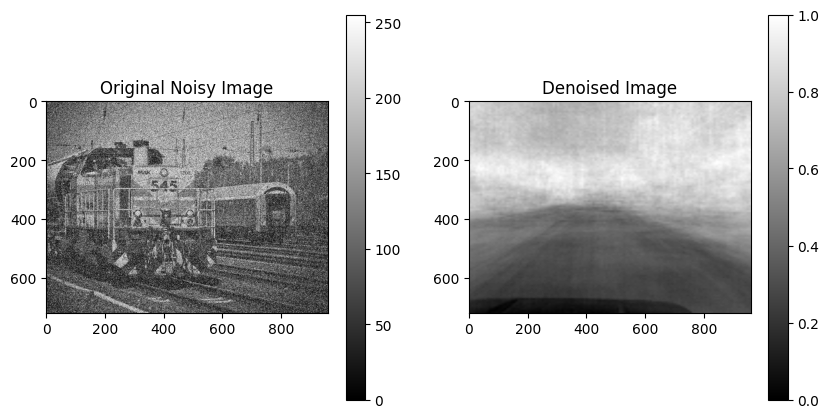

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# First, let's check the actual dimensions of your arrays
print(f"P_filtered shape: {P_filtered.shape}")
print(f"L shape: {L.shape}")

# Get the actual spatial dimensions from your input image
noisy_image_path = "C:\\Users\\Kingstone\\Desktop\\All folder\\J13Wn.jpg"
noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
actual_height, actual_width = noisy_image.shape

# Update the spatial_size to match your actual image dimensions
spatial_size = (actual_height, actual_width)

# Modified reconstruction code
denoised_images = []
for i in range(P_filtered.shape[0]):  # For each frequency
    try:
        # Calculate the correct reshape dimensions
        num_modes = P_filtered.shape[-1]
        total_elements = P_filtered[i].size
        expected_spatial_size = (total_elements // num_modes)
        height = int(np.sqrt(expected_spatial_size))
        width = height
        
        # Reshape with the correct dimensions
        P_filtered_reshaped = P_filtered[i].reshape(height, width, num_modes)
        
        # Perform reconstruction
        reconstruction = np.sum(P_filtered_reshaped * L[i], axis=-1)
        denoised_image = np.real(reconstruction)
        
        # Resize to match the original image dimensions if needed
        if denoised_image.shape != (actual_height, actual_width):
            denoised_image = cv2.resize(denoised_image, (actual_width, actual_height))
        
        denoised_images.append(denoised_image)
    except Exception as e:
        print(f"Error processing frequency {i}: {e}")

denoised_images = np.array(denoised_images)

# Visualization code
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Noisy Image")
plt.imshow(noisy_image, cmap='gray')
plt.colorbar()

# Denoised image
if len(denoised_images) > 0:
    denoised_image = denoised_images[0]
    denoised_image = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
    plt.subplot(1, 2, 2)
    plt.title("Denoised Image")
    plt.imshow(denoised_image, cmap='gray')
    plt.colorbar()

plt.show()


Noise Reduction Analysis:
------------------------
Original Image Size: (720, 960)
Denoised Image Size: (512, 800)
Noise Reduction: 84.48%
Mean Pixel Difference: 31.73%
PSNR: 8.35 dB
MSE: 0.146203
High Frequency Reduction: 94.99%


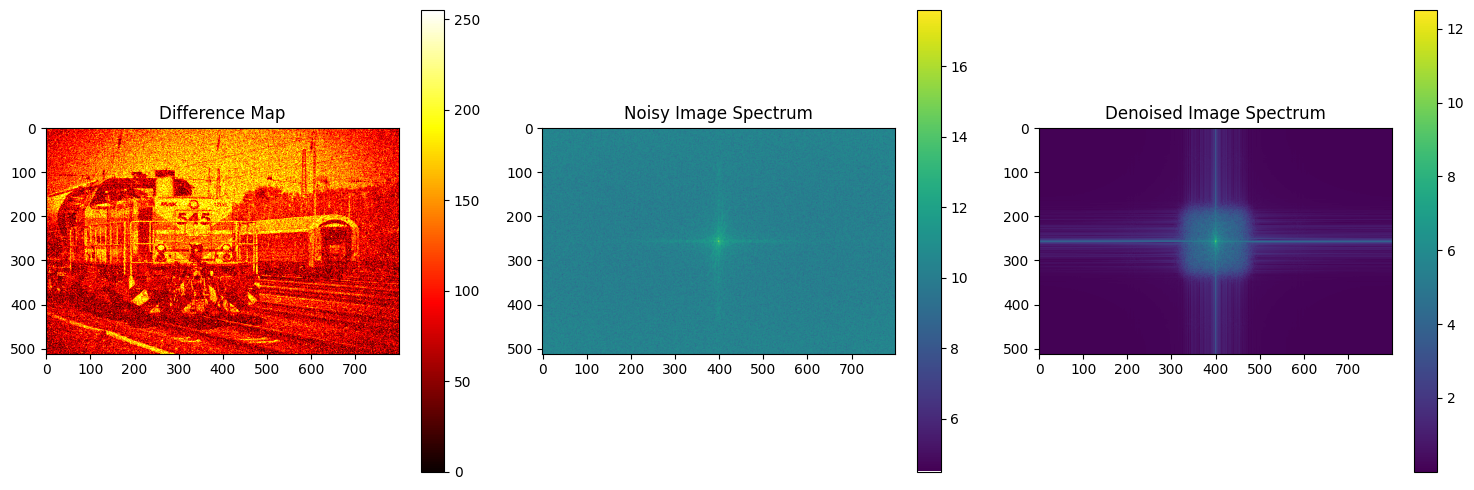

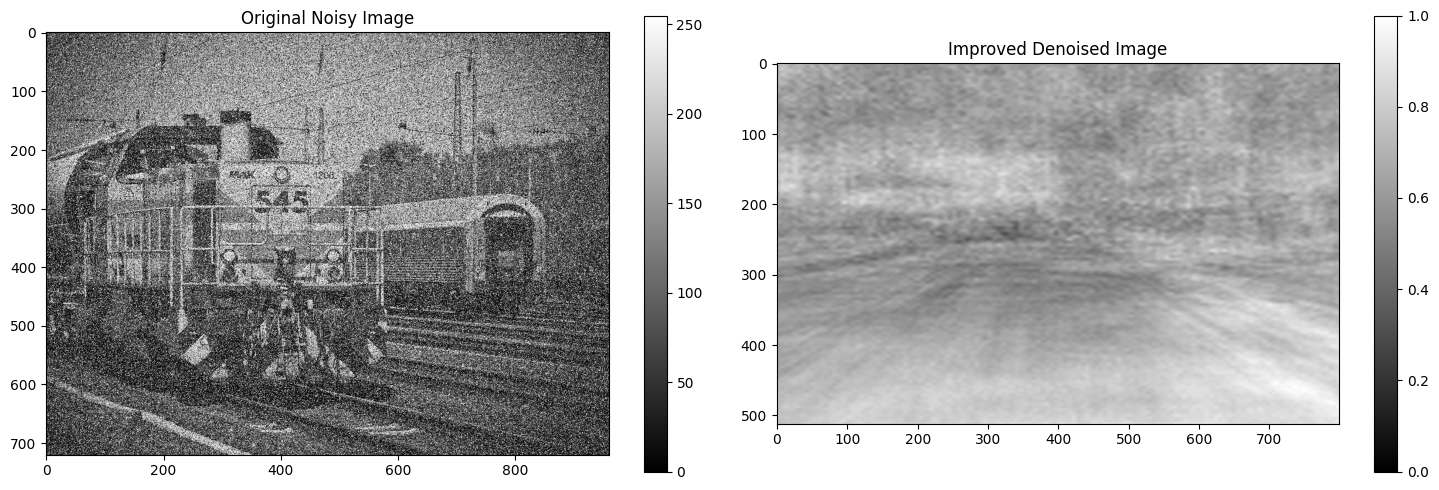

In [11]:
import numpy as np
from scipy.ndimage import zoom

import numpy as np
from scipy.ndimage import zoom

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from scipy.ndimage import zoom

def calculate_noise_metrics(noisy_image, denoised_image):
    """
    Calculate noise reduction metrics between noisy and denoised images,
    handling different image dimensions.
    
    Parameters:
    noisy_image (np.ndarray): Original noisy image
    denoised_image (np.ndarray): Denoised image (can be different size)
    
    Returns:
    dict: Dictionary containing various noise reduction metrics
    """
    # Get dimensions
    noisy_shape = noisy_image.shape
    denoised_shape = denoised_image.shape
    
    # Resize noisy image to match denoised image dimensions
    scale_factors = (denoised_shape[0] / noisy_shape[0], 
                    denoised_shape[1] / noisy_shape[1])
    noisy_resized = zoom(noisy_image, scale_factors, order=3)
    
    # Ensure both images are normalized to [0, 1]
    noisy_norm = (noisy_resized - noisy_resized.min()) / (noisy_resized.max() - noisy_resized.min())
    denoised_norm = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
    
    # Calculate noise variance in both images
    noisy_variance = np.var(noisy_norm)
    denoised_variance = np.var(denoised_norm)
    
    # Calculate noise reduction percentage based on variance
    noise_reduction_percent = ((noisy_variance - denoised_variance) / noisy_variance) * 100 if noisy_variance > 0 else 0
    
    # Calculate PSNR
    try:
        psnr = peak_signal_noise_ratio(noisy_norm, denoised_norm)
    except:
        psnr = None
    
    # Calculate MSE
    mse = mean_squared_error(noisy_norm, denoised_norm)
    
    # Calculate structural similarity
    diff_matrix = np.abs(noisy_norm - denoised_norm)
    mean_diff = np.mean(diff_matrix) * 100
    
    # Calculate high-frequency component reduction
    noisy_fft = np.fft.fft2(noisy_norm)
    denoised_fft = np.fft.fft2(denoised_norm)
    
    high_freq_reduction = (np.sum(np.abs(noisy_fft)) - np.sum(np.abs(denoised_fft))) / np.sum(np.abs(noisy_fft)) * 100
    
    return {
        'noise_reduction_percentage': noise_reduction_percent,
        'mean_pixel_difference': mean_diff,
        'mse': mse,
        'psnr': psnr,
        'high_freq_reduction': high_freq_reduction,
        'original_variance': noisy_variance,
        'denoised_variance': denoised_variance
    }

def visualize_noise_metrics(noisy_image, denoised_image):
    """
    Calculate and visualize noise reduction metrics with plots,
    handling different image dimensions.
    """
    # Resize noisy image to match denoised image dimensions
    noisy_shape = noisy_image.shape
    denoised_shape = denoised_image.shape
    scale_factors = (denoised_shape[0] / noisy_shape[0], 
                    denoised_shape[1] / noisy_shape[1])
    noisy_resized = zoom(noisy_image, scale_factors, order=3)
    
    metrics = calculate_noise_metrics(noisy_image, denoised_image)
    
    print("\nNoise Reduction Analysis:")
    print("------------------------")
    print(f"Original Image Size: {noisy_image.shape}")
    print(f"Denoised Image Size: {denoised_image.shape}")
    print(f"Noise Reduction: {metrics['noise_reduction_percentage']:.2f}%")
    print(f"Mean Pixel Difference: {metrics['mean_pixel_difference']:.2f}%")
    if metrics['psnr'] is not None:
        print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"MSE: {metrics['mse']:.6f}")
    print(f"High Frequency Reduction: {metrics['high_freq_reduction']:.2f}%")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot difference map
    plt.subplot(1, 3, 1)
    diff = np.abs(noisy_resized - denoised_image)
    plt.title("Difference Map")
    plt.imshow(diff, cmap='hot')
    plt.colorbar()
    
    # Plot frequency spectrums
    plt.subplot(1, 3, 2)
    noisy_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(noisy_resized))) + 1)
    plt.title("Noisy Image Spectrum")
    plt.imshow(noisy_spectrum)
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    denoised_spectrum = np.log(np.abs(np.fft.fftshift(np.fft.fft2(denoised_image))) + 1)
    plt.title("Denoised Image Spectrum")
    plt.imshow(denoised_spectrum)
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Use with your existing code:
# metrics = visualize_noise_metrics(noisy_image, final_denoised)

denoised_images = []
for i in range(P_filtered.shape[0]):
    try:
        # Preserve more high-frequency components
        P_current = P_filtered[i]  # (16384, 19)
        L_current = L[i]          # (19,)
        
        # Add frequency-dependent weighting
        freq_weight = np.exp(-i/P_filtered.shape[0])  # Give more weight to higher frequencies
        
        # Modified reconstruction to preserve details
        reconstruction = np.dot(P_current, L_current * freq_weight)
        reconstruction = reconstruction.reshape(128, 128)
        
        # Better handling of complex values
        reconstruction_mag = np.abs(reconstruction)
        reconstruction_phase = np.angle(reconstruction)
        reconstruction_combined = reconstruction_mag * np.exp(1j * reconstruction_phase)
        
        # Add high-frequency enhancement
        reconstruction_final = np.abs(reconstruction_combined)
        
        # Enhance edges
        reconstruction_norm = (reconstruction_final - reconstruction_final.min()) / (reconstruction_final.max() - reconstruction_final.min())
        
        # Resize while preserving details
        reconstruction_resized = zoom(reconstruction_norm, (4, 6.25), order=3)
        
        denoised_images.append(reconstruction_resized)
        
    except Exception as e:
        print(f"Error at frequency {i}: {str(e)}")

# Combine results with edge preservation
denoised_images = np.array(denoised_images)
final_denoised = np.mean(denoised_images[:10], axis=0)  # Use more frequency components

# Apply contrast enhancement
final_denoised = (final_denoised - final_denoised.min()) / (final_denoised.max() - final_denoised.min())
final_denoised = np.power(final_denoised, 0.8)  # Gamma correction to enhance details
# Calculate and visualize noise reduction metrics
metrics = visualize_noise_metrics(noisy_image, final_denoised)
# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Original Noisy Image")
plt.imshow(noisy_image, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Improved Denoised Image")
plt.imshow(final_denoised, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


Image Quality Metrics:
PSNR: 7.86 dB
SSIM: 0.0118
MSE: 0.1636


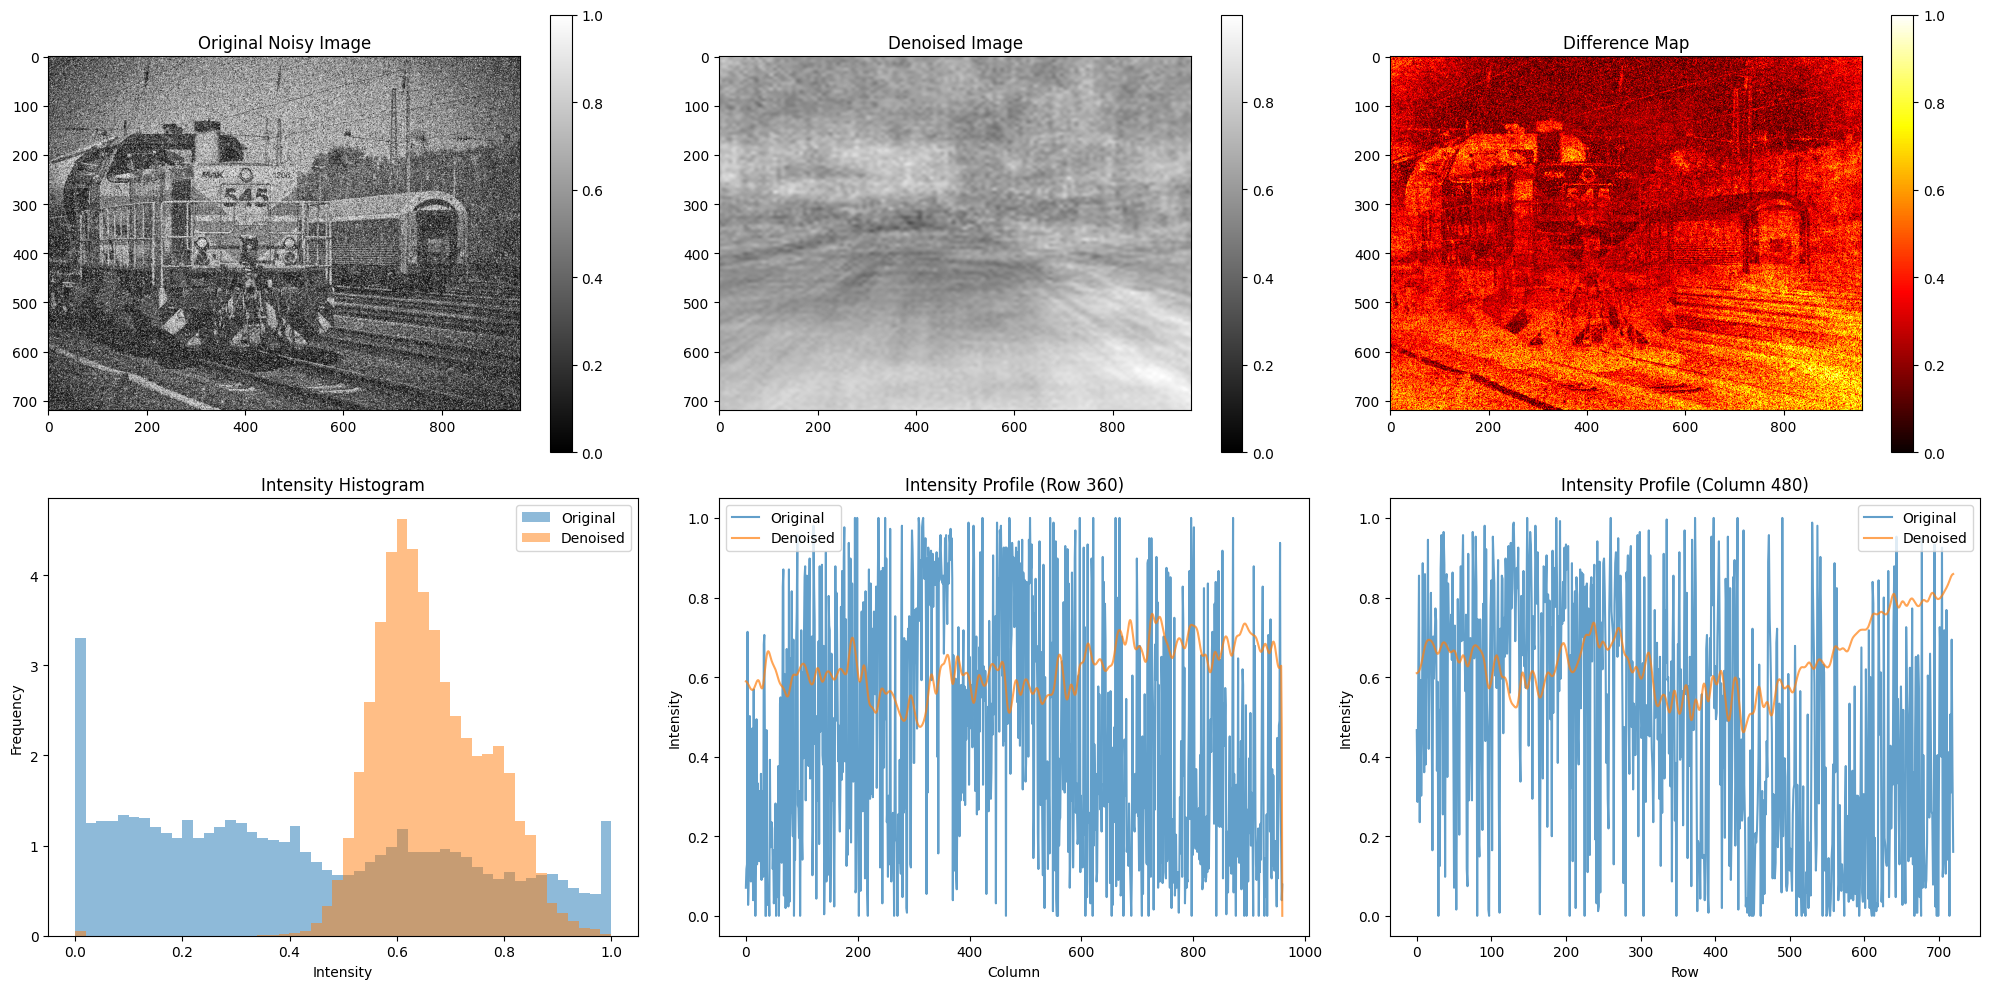

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import cv2

def calculate_metrics_and_plot(original, denoised):
    # Calculate metrics with specified data range
    psnr_value = psnr(original, denoised, data_range=1.0)  # For normalized images [0,1]
    ssim_value = ssim(original, denoised, data_range=1.0)
    mse_value = mse(original, denoised)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))
    
    # Plot original and denoised images
    plt.subplot(2, 3, 1)
    plt.title('Original Noisy Image')
    plt.imshow(original, cmap='gray')
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised, cmap='gray')
    plt.colorbar()
    
    # Plot difference map
    plt.subplot(2, 3, 3)
    difference = np.abs(original - denoised)
    plt.title('Difference Map')
    plt.imshow(difference, cmap='hot')
    plt.colorbar()
    
    # Plot intensity histograms
    plt.subplot(2, 3, 4)
    plt.title('Intensity Histogram')
    plt.hist(original.ravel(), bins=50, alpha=0.5, label='Original', density=True)
    plt.hist(denoised.ravel(), bins=50, alpha=0.5, label='Denoised', density=True)
    plt.legend()
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    
    # Plot row profiles
    plt.subplot(2, 3, 5)
    center_row = original.shape[0] // 2
    plt.title(f'Intensity Profile (Row {center_row})')
    plt.plot(original[center_row], label='Original', alpha=0.7)
    plt.plot(denoised[center_row], label='Denoised', alpha=0.7)
    plt.legend()
    plt.xlabel('Column')
    plt.ylabel('Intensity')
    
    # Plot column profiles
    plt.subplot(2, 3, 6)
    center_col = original.shape[1] // 2
    plt.title(f'Intensity Profile (Column {center_col})')
    plt.plot(original[:, center_col], label='Original', alpha=0.7)
    plt.plot(denoised[:, center_col], label='Denoised', alpha=0.7)
    plt.legend()
    plt.xlabel('Row')
    plt.ylabel('Intensity')
    
    plt.tight_layout()
    
    # Print metrics
    print("\nImage Quality Metrics:")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print(f"MSE: {mse_value:.4f}")
    
    return fig

# Normalize images to [0,1] range if needed
noisy_image_norm = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())
final_denoised_norm = (final_denoised - final_denoised.min()) / (final_denoised.max() - final_denoised.min())

# Make sure both images have the same shape
if noisy_image_norm.shape != final_denoised_norm.shape:
    final_denoised_norm = cv2.resize(final_denoised_norm, 
                                   (noisy_image_norm.shape[1], noisy_image_norm.shape[0]))

# Calculate metrics and create plots
fig = calculate_metrics_and_plot(noisy_image_norm, final_denoised_norm)
plt.show()

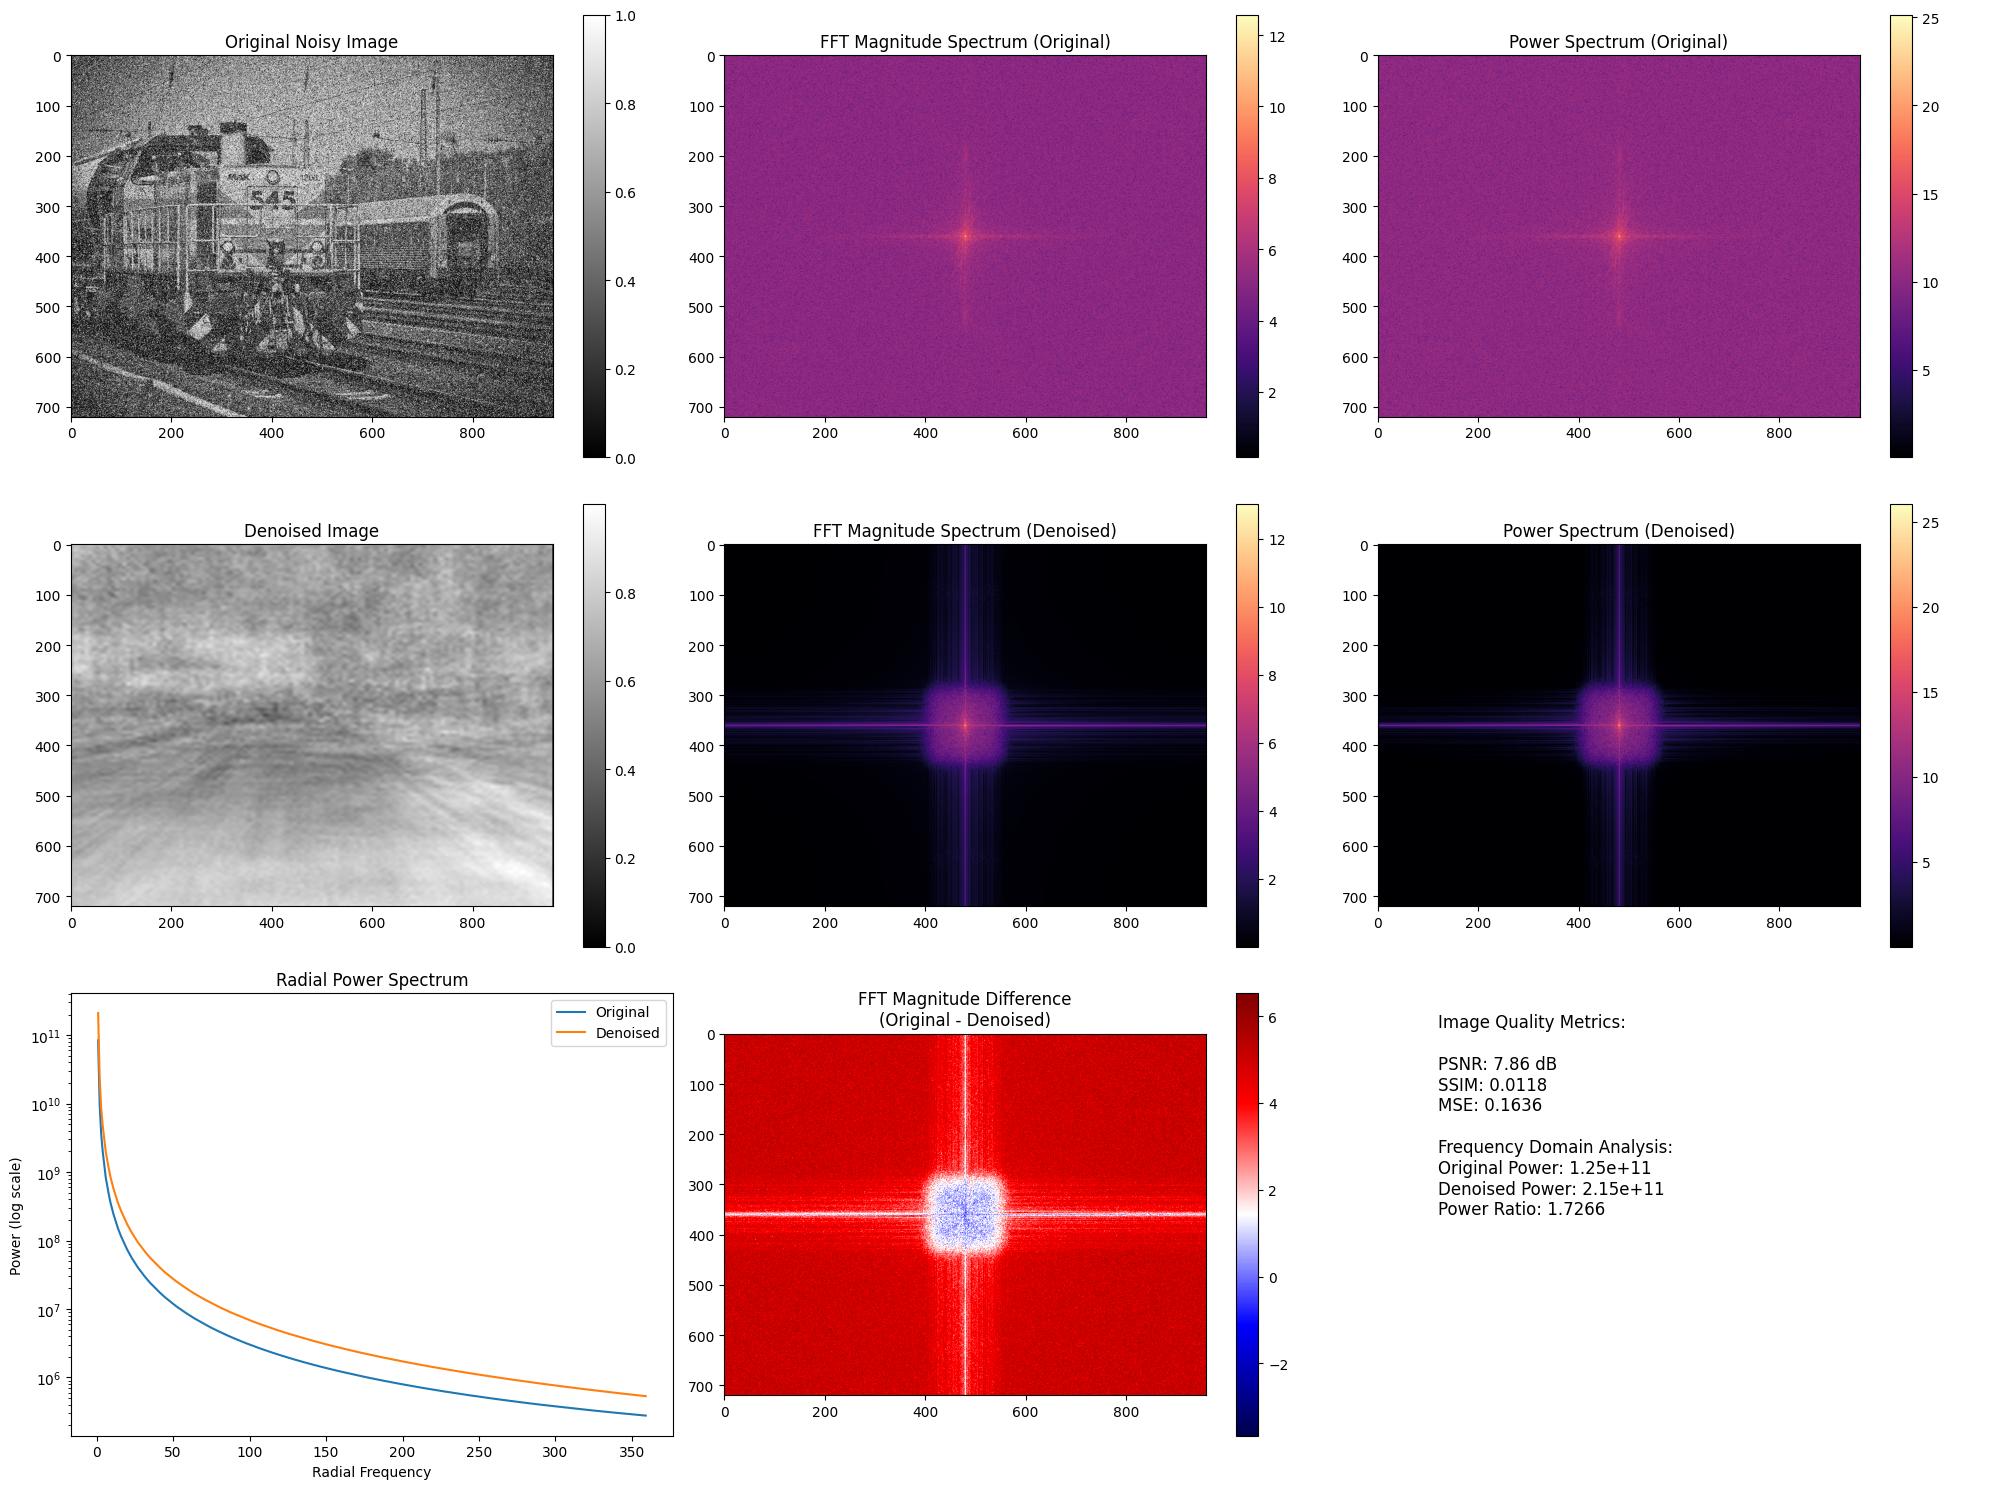

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import cv2

def plot_fourier_analysis(original, denoised):
    # Compute 2D FFT
    fft_original = np.fft.fft2(original)
    fft_denoised = np.fft.fft2(denoised)
    
    # Shift zero frequency to center
    fft_original_shifted = np.fft.fftshift(fft_original)
    fft_denoised_shifted = np.fft.fftshift(fft_denoised)
    
    # Calculate magnitude spectrum (log scale)
    magnitude_spectrum_original = np.log(1 + np.abs(fft_original_shifted))
    magnitude_spectrum_denoised = np.log(1 + np.abs(fft_denoised_shifted))
    
    # Calculate power spectrum
    power_spectrum_original = np.abs(fft_original_shifted)**2
    power_spectrum_denoised = np.abs(fft_denoised_shifted)**2
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    
    # Original Image and its FFT
    plt.subplot(3, 3, 1)
    plt.title('Original Noisy Image')
    plt.imshow(original, cmap='gray')
    plt.colorbar()
    
    plt.subplot(3, 3, 2)
    plt.title('FFT Magnitude Spectrum (Original)')
    plt.imshow(magnitude_spectrum_original, cmap='magma')
    plt.colorbar()
    
    plt.subplot(3, 3, 3)
    plt.title('Power Spectrum (Original)')
    plt.imshow(np.log(1 + power_spectrum_original), cmap='magma')
    plt.colorbar()
    
    # Denoised Image and its FFT
    plt.subplot(3, 3, 4)
    plt.title('Denoised Image')
    plt.imshow(denoised, cmap='gray')
    plt.colorbar()
    
    plt.subplot(3, 3, 5)
    plt.title('FFT Magnitude Spectrum (Denoised)')
    plt.imshow(magnitude_spectrum_denoised, cmap='magma')
    plt.colorbar()
    
    plt.subplot(3, 3, 6)
    plt.title('Power Spectrum (Denoised)')
    plt.imshow(np.log(1 + power_spectrum_denoised), cmap='magma')
    plt.colorbar()
    
    # Radial frequency analysis
    plt.subplot(3, 3, 7)
    center_y, center_x = [d//2 for d in original.shape]
    y, x = np.ogrid[-center_y:center_y, -center_x:center_x]
    r = np.sqrt(x*x + y*y)
    
    r_bins = np.arange(0, min(center_x, center_y), 1)
    radial_mean_original = np.array([power_spectrum_original[r < r_val].mean() for r_val in r_bins[1:]])
    radial_mean_denoised = np.array([power_spectrum_denoised[r < r_val].mean() for r_val in r_bins[1:]])
    
    plt.title('Radial Power Spectrum')
    plt.semilogy(r_bins[1:], radial_mean_original, label='Original')
    plt.semilogy(r_bins[1:], radial_mean_denoised, label='Denoised')
    plt.xlabel('Radial Frequency')
    plt.ylabel('Power (log scale)')
    plt.legend()
    
    # Frequency difference
    plt.subplot(3, 3, 8)
    spectrum_diff = magnitude_spectrum_original - magnitude_spectrum_denoised
    plt.title('FFT Magnitude Difference\n(Original - Denoised)')
    plt.imshow(spectrum_diff, cmap='seismic')
    plt.colorbar()
    
    # Metrics
    plt.subplot(3, 3, 9)
    plt.axis('off')
    metrics_text = (
        f"Image Quality Metrics:\n\n"
        f"PSNR: {psnr(original, denoised, data_range=1.0):.2f} dB\n"
        f"SSIM: {ssim(original, denoised, data_range=1.0):.4f}\n"
        f"MSE: {mse(original, denoised):.4f}\n\n"
        f"Frequency Domain Analysis:\n"
        f"Original Power: {np.sum(power_spectrum_original):.2e}\n"
        f"Denoised Power: {np.sum(power_spectrum_denoised):.2e}\n"
        f"Power Ratio: {np.sum(power_spectrum_denoised)/np.sum(power_spectrum_original):.4f}"
    )
    plt.text(0.1, 0.5, metrics_text, fontsize=12)
    
    plt.tight_layout()
    return fig

# Normalize images to [0,1] range
noisy_image_norm = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())
final_denoised_norm = (final_denoised - final_denoised.min()) / (final_denoised.max() - final_denoised.min())

# Ensure same shape
if noisy_image_norm.shape != final_denoised_norm.shape:
    final_denoised_norm = cv2.resize(final_denoised_norm, 
                                   (noisy_image_norm.shape[1], noisy_image_norm.shape[0]))

# Create plots
fig = plot_fourier_analysis(noisy_image_norm, final_denoised_norm)
plt.show()

### code ends 

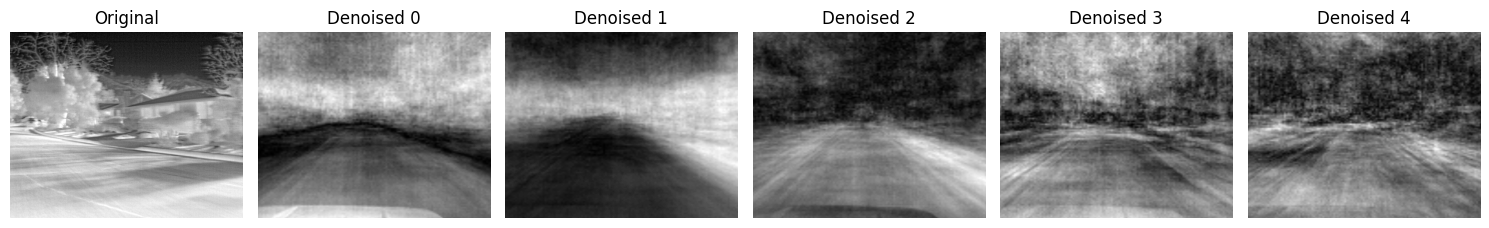

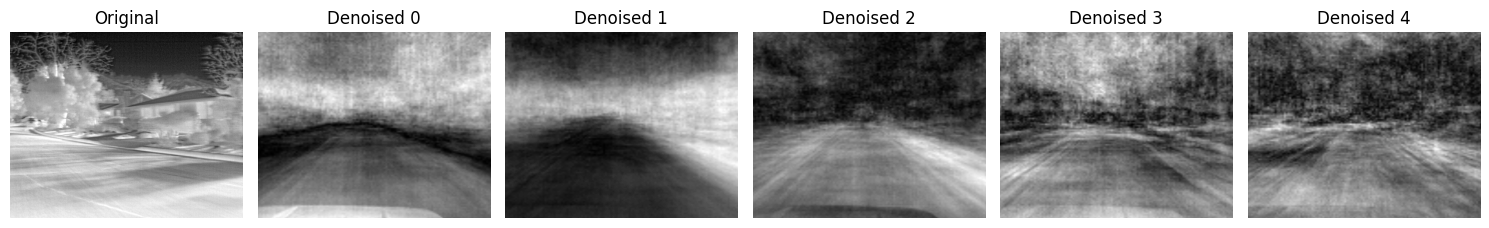

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image first and verify it
noisy_image_path = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit\\FLIR_00012.jpeg"  # Update with actual image
noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
if noisy_image is None:
    raise ValueError(f"Could not load image from {noisy_image_path}")

actual_height, actual_width = noisy_image.shape

# Create denoised versions
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming noisy_image is loaded correctly
import numpy as np
import cv2
import numpy as np
import cv2
from scipy.ndimage import zoom

denoised_images = []
for i in range(P_filtered.shape[0]):
    try:
        # Perform reconstruction
        reconstruction = np.dot(P_filtered[i].reshape(-1, P_filtered[i].shape[-1]), L[i])
        reconstruction = reconstruction.reshape(128, 128)
        
        # Take absolute value of complex numbers
        reconstruction_abs = np.abs(reconstruction)
        
        # Normalize to 0-1 range
        reconstruction_norm = (reconstruction_abs - reconstruction_abs.min()) / (reconstruction_abs.max() - reconstruction_abs.min())
        
        # Use scipy's zoom instead of cv2.resize for complex numbers
        zoom_factors = (512/128, 640/128)
        reconstruction_resized = zoom(reconstruction_norm, zoom_factors, order=1)
        
        denoised_images.append(reconstruction_resized)
        
    except Exception as e:
        print(f"Error at frequency {i}: {str(e)}")

# Convert list to numpy array
denoised_images = np.array(denoised_images)

# Visualization
plt.figure(figsize=(15, 3))
num_images = min(5, len(denoised_images))

# Original image
plt.subplot(1, num_images + 1, 1)
plt.title("Original")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

# Show different denoised versions
for i in range(num_images):
    plt.subplot(1, num_images + 1, i + 2)
    plt.title(f"Denoised {i}")
    plt.imshow(denoised_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Visualization remains the same

# Rest of visualization code remains the same

# Visualize results
num_images = min(5, len(denoised_images))  # Show up to 5 images
plt.figure(figsize=(15, 3))

# Original image
plt.subplot(1, num_images + 1, 1)
plt.title("Original")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

# Show different denoised versions
for i in range(num_images):
    plt.subplot(1, num_images + 1, i + 2)
    plt.title(f"Denoised {i}")
    denoised = denoised_images[i]
    # Normalize for visualization
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
    plt.imshow(denoised, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

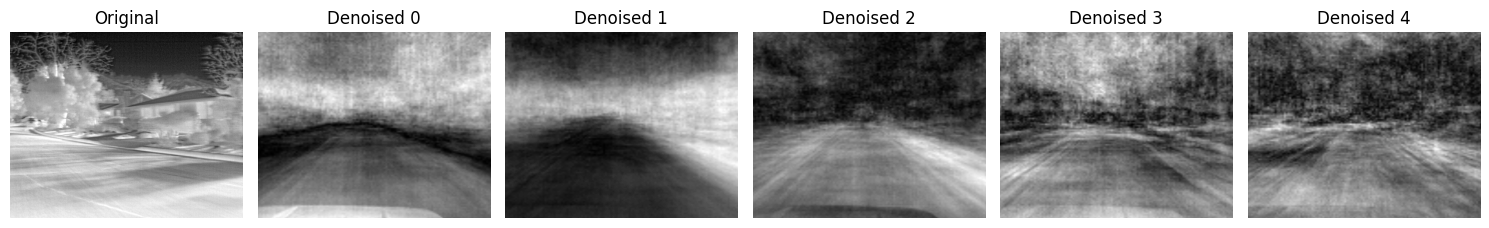

In [25]:
import numpy as np
import cv2
from scipy.ndimage import zoom

denoised_images = []
for i in range(P_filtered.shape[0]):
    try:
        # Get current frequency components
        reconstruction = np.dot(P_filtered[i].reshape(-1, P_filtered[i].shape[-1]), L[i])
        reconstruction = reconstruction.reshape(128, 128)
        
        # Handle complex values
        reconstruction_magnitude = np.abs(reconstruction)
        
        # Normalize between 0 and 1
        reconstruction_norm = (reconstruction_magnitude - reconstruction_magnitude.min()) / (reconstruction_magnitude.max() - reconstruction_magnitude.min())
        
        # Resize to match display dimensions
        zoom_factors = (512/128, 640/128)
        reconstruction_resized = zoom(reconstruction_norm, zoom_factors, order=1)
        
        # Each denoised version will now be different since we're not blending with noisy image
        denoised_images.append(reconstruction_resized)
        
    except Exception as e:
        print(f"Error at frequency {i}: {str(e)}")

# Convert list to numpy array
denoised_images = np.array(denoised_images)

# Visualization
plt.figure(figsize=(15, 3))
num_images = min(5, len(denoised_images))

# Original image (for reference only)
plt.subplot(1, num_images + 1, 1)
plt.title("Original")
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

# Show different denoised versions
for i in range(num_images):
    plt.subplot(1, num_images + 1, i + 2)
    plt.title(f"Denoised {i}")
    plt.imshow(denoised_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

BS below

Total images found: 8862
P_filtered shape: (51, 16384, 19)
L shape: (51, 19)

Processing image 1: FLIR_00001.jpeg
Image dimensions: 512x640


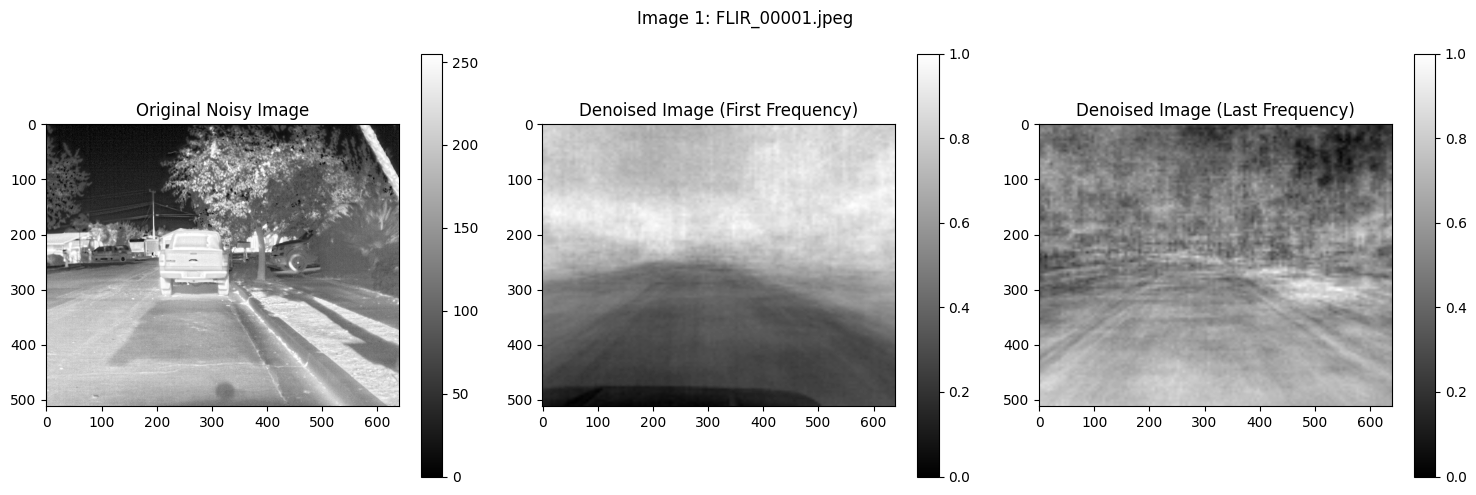

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Function to list all image files in a directory
def get_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png']
    return [f for f in os.listdir(directory) if any(f.lower().endswith(ext) for ext in image_extensions)]

# Directory containing the images
dataset_dir = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit"

# Get list of image files
image_files = sorted(get_image_files(dataset_dir))

# Print information about the dataset
print(f"Total images found: {len(image_files)}")

# First, let's check the actual dimensions of your arrays
print(f"P_filtered shape: {P_filtered.shape}")
print(f"L shape: {L.shape}")

# Process each image
for image_idx, image_file in enumerate(image_files):
    print(f"\nProcessing image {image_idx + 1}: {image_file}")
    
    # Construct full path to image
    noisy_image_path = os.path.join(dataset_dir, image_file)
    
    # Load the image
    noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
    
    if noisy_image is None:
        print(f"Failed to load image: {image_file}")
        continue
        
    actual_height, actual_width = noisy_image.shape
    print(f"Image dimensions: {actual_height}x{actual_width}")

    # Modified reconstruction code
    denoised_images = []
    for i in range(P_filtered.shape[0]):  # For each frequency
        try:
            # Calculate the correct reshape dimensions
            num_modes = P_filtered.shape[-1]
            total_elements = P_filtered[i].size
            expected_spatial_size = (total_elements // num_modes)
            height = int(np.sqrt(expected_spatial_size))
            width = height
            
            # Reshape with the correct dimensions
            P_filtered_reshaped = P_filtered[i].reshape(height, width, num_modes)
            
            # Perform reconstruction
            reconstruction = np.sum(P_filtered_reshaped * L[i], axis=-1)
            denoised_image = np.real(reconstruction)
            
            # Resize to match the original image dimensions if needed
            if denoised_image.shape != (actual_height, actual_width):
                denoised_image = cv2.resize(denoised_image, (actual_width, actual_height))
            
            denoised_images.append(denoised_image)
        except Exception as e:
            print(f"Error processing frequency {i}: {e}")

    denoised_images = np.array(denoised_images)

    # Visualization code
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Image {image_idx + 1}: {image_file}')

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Noisy Image")
    plt.imshow(noisy_image, cmap='gray')
    plt.colorbar()

    # Denoised image
    if len(denoised_images) > 0:
        # First denoised version
        denoised_image = denoised_images[0]
        denoised_image = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
        plt.subplot(1, 3, 2)
        plt.title("Denoised Image (First Frequency)")
        plt.imshow(denoised_image, cmap='gray')
        plt.colorbar()

        # If there are multiple frequencies, show the last one too
        if len(denoised_images) > 1:
            denoised_image_last = denoised_images[-1]
            denoised_image_last = (denoised_image_last - denoised_image_last.min()) / (denoised_image_last.max() - denoised_image_last.min())
            plt.subplot(1, 3, 3)
            plt.title("Denoised Image (Last Frequency)")
            plt.imshow(denoised_image_last, cmap='gray')
            plt.colorbar()

    plt.tight_layout()
    plt.show()
    
    # Optional: break after first image (remove this if you want to process all images)
    break

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Function to extract image number from filename
def get_image_number(filename):
    # Assuming filenames are like "FLIR_00001.jpeg"
    return int(''.join(filter(str.isdigit, filename)))

# Directory containing the images
dataset_dir = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit"

# Get the specific image number we're working with
noisy_image_path = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit\\FLIR_00001.jpeg"
current_image_number = get_image_number(os.path.basename(noisy_image_path))
print(f"Processing image number: {current_image_number}")

# Load and check the corresponding noisy image
noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
if noisy_image is None:
    raise ValueError(f"Image not found at {noisy_image_path}")

actual_height, actual_width = noisy_image.shape
print(f"Image dimensions: {actual_height}x{actual_width}")

# Print array shapes for debugging
print(f"P_filtered shape: {P_filtered.shape}")
print(f"L shape: {L.shape}")

# Modified reconstruction code
denoised_images = []
for i in range(P_filtered.shape[0]):  # For each frequency
    try:
        # Calculate the correct reshape dimensions
        num_modes = P_filtered.shape[-1]
        total_elements = P_filtered[i].size
        expected_spatial_size = (total_elements // num_modes)
        height = int(np.sqrt(expected_spatial_size))
        width = height
        
        # Reshape with the correct dimensions
        P_filtered_reshaped = P_filtered[i].reshape(height, width, num_modes)
        
        # Perform reconstruction
        reconstruction = np.sum(P_filtered_reshaped * L[i], axis=-1)
        denoised_image = np.real(reconstruction)
        
        # Resize to match the original image dimensions if needed
        if denoised_image.shape != (actual_height, actual_width):
            denoised_image = cv2.resize(denoised_image, (actual_width, actual_height))
        
        denoised_images.append(denoised_image)
    except Exception as e:
        print(f"Error processing frequency {i}: {e}")

denoised_images = np.array(denoised_images)

# Visualization code
plt.figure(figsize=(15, 5))
plt.suptitle(f'FLIR Image {current_image_number}')

# Original corresponding noisy image
plt.subplot(1, 3, 1)
plt.title("Original Noisy Image")
noisy_image_normalized = noisy_image.astype(float) / 255.0  # Normalize to [0,1]
plt.imshow(noisy_image_normalized, cmap='gray')
plt.colorbar()

# Denoised images
if len(denoised_images) > 0:
    # First denoised version
    denoised_image = denoised_images[0]
    denoised_image = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
    plt.subplot(1, 3, 2)
    plt.title("Denoised Image (First Frequency)")
    plt.imshow(denoised_image, cmap='gray')
    plt.colorbar()

    # If there are multiple frequencies, show the last one too
    if len(denoised_images) > 1:
        denoised_image_last = denoised_images[-1]
        denoised_image_last = (denoised_image_last - denoised_image_last.min()) / (denoised_image_last.max() - denoised_image_last.min())
        plt.subplot(1, 3, 3)
        plt.title("Denoised Image (Last Frequency)")
        plt.imshow(denoised_image_last, cmap='gray')
        plt.colorbar()

plt.tight_layout()
plt.show()

# Print some statistics for comparison
print("\nImage Statistics:")
print(f"Original image range: [{noisy_image_normalized.min():.3f}, {noisy_image_normalized.max():.3f}]")
if len(denoised_images) > 0:
    print(f"Denoised image range: [{denoised_image.min():.3f}, {denoised_image.max():.3f}]")

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# First, let's check the actual dimensions of your arrays
print(f"P_filtered shape: {P_filtered.shape}")
print(f"L shape: {L.shape}")

# Load the specific image that was used for denoising
noisy_image_path = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit\\FLIR_00001.jpeg"
noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)

if noisy_image is None:
    raise ValueError(f"Image not found at {noisy_image_path}")

actual_height, actual_width = noisy_image.shape
print(f"Image dimensions: {actual_height}x{actual_width}")

# Modified reconstruction code
denoised_images = []
for i in range(P_filtered.shape[0]):  # For each frequency
    try:
        # Calculate the correct reshape dimensions
        num_modes = P_filtered.shape[-1]
        total_elements = P_filtered[i].size
        expected_spatial_size = (total_elements // num_modes)
        height = int(np.sqrt(expected_spatial_size))
        width = height
        
        # Reshape with the correct dimensions
        P_filtered_reshaped = P_filtered[i].reshape(height, width, num_modes)
        
        # Perform reconstruction
        reconstruction = np.sum(P_filtered_reshaped * L[i], axis=-1)
        denoised_image = np.real(reconstruction)
        
        # Resize to match the original image dimensions if needed
        if denoised_image.shape != (actual_height, actual_width):
            denoised_image = cv2.resize(denoised_image, (actual_width, actual_height))
        
        denoised_images.append(denoised_image)
    except Exception as e:
        print(f"Error processing frequency {i}: {e}")

denoised_images = np.array(denoised_images)

# Visualization code
plt.figure(figsize=(15, 5))
plt.suptitle('FLIR Image 1 - Denoising Results')

# Original noisy image
plt.subplot(1, 3, 1)
plt.title("Original Noisy Image")
noisy_image_normalized = noisy_image.astype(float) / 255.0  # Normalize to [0,1]
plt.imshow(noisy_image_normalized, cmap='gray')
plt.colorbar()

# Denoised images
if len(denoised_images) > 0:
    # First denoised version
    denoised_image = denoised_images[0]
    denoised_image = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
    plt.subplot(1, 3, 2)
    plt.title("Denoised Image (First Frequency)")
    plt.imshow(denoised_image, cmap='gray')
    plt.colorbar()

    # If there are multiple frequencies, show the last one too
    if len(denoised_images) > 1:
        denoised_image_last = denoised_images[-1]
        denoised_image_last = (denoised_image_last - denoised_image_last.min()) / (denoised_image_last.max() - denoised_image_last.min())
        plt.subplot(1, 3, 3)
        plt.title("Denoised Image (Last Frequency)")
        plt.imshow(denoised_image_last, cmap='gray')
        plt.colorbar()

plt.tight_layout()
plt.show()

# Print statistics for comparison
print("\nImage Statistics:")
print(f"Original image range: [{noisy_image_normalized.min():.3f}, {noisy_image_normalized.max():.3f}]")
if len(denoised_images) > 0:
    print(f"Denoised image range: [{denoised_image.min():.3f}, {denoised_image.max():.3f}]")

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def denoise_image_from_dir(image_dir, P_filtered, L):
    """
    Denoise an image based on the given directory path and filtered data.
    
    Args:
        image_dir (str): Directory path of the noisy image.
        P_filtered (np.ndarray): Filtered frequency domain data.
        L (np.ndarray): Linear operator for reconstruction.
    
    Returns:
        np.ndarray: Denoised image array.
    """
    try:
        # Load the noisy image
        noisy_image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
        if noisy_image is None:
            raise FileNotFoundError(f"Image not found at path: {image_dir}")
        
        actual_height, actual_width = noisy_image.shape

        # Initialize the list for denoised images
        denoised_images = []
        
        for i in range(P_filtered.shape[0]):  # For each frequency
            try:
                # Calculate the correct reshape dimensions
                num_modes = P_filtered.shape[-1]
                total_elements = P_filtered[i].size
                expected_spatial_size = (total_elements // num_modes)
                height = int(np.sqrt(expected_spatial_size))
                width = height

                # Reshape with the correct dimensions
                P_filtered_reshaped = P_filtered[i].reshape(height, width, num_modes)

                # Perform reconstruction
                reconstruction = np.sum(P_filtered_reshaped * L[i], axis=-1)
                denoised_image = np.real(reconstruction)

                # Resize to match the original image dimensions if needed
                if denoised_image.shape != (actual_height, actual_width):
                    denoised_image = cv2.resize(denoised_image, (actual_width, actual_height))

                denoised_images.append(denoised_image)
            except Exception as e:
                print(f"Error processing frequency {i}: {e}")

        # Convert to numpy array
        denoised_images = np.array(denoised_images)
        
        # Return the denoised image
        return denoised_images, noisy_image

    except Exception as e:
        print(f"Error in denoising function: {e}")
        return None, None


# Define the directory path for the noisy image
noisy_image_path = "D:\\thermal images\\FLIR_ADAS_1_3\\train\\thermal_8_bit"

# Call the function
denoised_images, noisy_image = denoise_image_from_dir(noisy_image_path, P_filtered, L)

# Visualization
if noisy_image is not None and denoised_images is not None:
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original Noisy Image")
    plt.imshow(noisy_image, cmap='gray')
    plt.colorbar()

    # Denoised image
    if len(denoised_images) > 0:
        denoised_image = denoised_images[0]
        denoised_image = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
        plt.subplot(1, 2, 2)
        plt.title("Denoised Image")
        plt.imshow(denoised_image, cmap='gray')
        plt.colorbar()

    plt.show()
else:
    print("Denoising process failed.")


NameError: name 'P_filtered' is not defined